# 4.6.1 Análisis y preparación de los datos históricos

Durante este documento se analizarán los datos históricos recolectados desde el 1 de julio de 2019 hasta el 30 de junio de  2021.

Posteriormente, se prepararán los datos para utilizarlos al momento de realizar los modelos de predicción.

#### Importando librerías

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#### Carga del archivo

In [2]:
data_file = os.getcwd().split("TFG")[0] + "TFG\\apis\historical_apis\out_historical_apis\merge_historical\\2019-2021-2Y\historical_data_2019-2021-2Y.csv"
df = pd.read_csv(data_file, low_memory=False) 
df.shape

### 4.6.1.1 Inspeccionar y limpiar

El modelo que se realizará es un modelo predictivo para predecir la calidad del aire en la ciudad de Nueva York, específicamente en la zona de Manhattan. 

Los datos recolectados incluyen dos valores de índice de calidad del aire (AQI, por sus siglas en inglés) uno para los niveles de concentración del PM2.5 y otro para el OZONO. 

Para generar el modelo predictivo se incorporará a los datos una columna 'AQI' que será igual al mayor de los valores de los AQIs recolectados, es decir, AQI = max(AQI_PM2.5, AQI_OZONE)

Antes de esto, se hará una primera limpieza de las columnas y se observaran las estadísticas del conjunto de datos.


In [ ]:
df.columns

Index(['datetime', 'datetime_traffic', 'weekday', 'speed', 'travel_time',
       'link_name', 'AQI_PM2.5', 'AQI_OZONE', 'Minimum Temperature',
       'Maximum Temperature', 'Temperature', 'Dew Point', 'Relative Humidity',
       'Wind Speed', 'Wind Direction', 'Precipitation', 'Precipitation Cover',
       'Snow Depth', 'Visibility', 'Cloud Cover', 'Sea Level Pressure',
       'Conditions'],
      dtype='object')

Observando las columnas del dataframe se pueden descartar algunas directamente ya que no aportan valor e información relevante para el modelo predictivo.

Se borran las siguientes columnas:
 - `datetime_traffic`: ya se cuenta con una columna `datetime` que indica la hora en la que fue recolectada la información.
 - `link_name`: el modelo se realizará para todo Manhattan por lo que es irrelevante la calle en la que se registran los datos.
 

In [ ]:
df.drop(['datetime_traffic', 'link_name'], axis=1, inplace=True) 

A continuación, se observan las estadísticas del conjunto de datos:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,4636686.0,24.550146,16.397229,0.00,11.18,25.47,37.90,119.30
travel_time,4636686.0,288.068564,922.259726,-28.00,86.00,172.00,345.00,339515.00
AQI_PM2.5,4263902.0,24.637792,36.685186,-999.00,15.00,23.00,34.00,103.00
AQI_OZONE,4589514.0,23.073167,12.636496,0.00,15.00,22.00,31.00,119.00
Minimum Temperature,4634436.0,55.469998,20.664627,-19.10,38.60,56.20,72.60,102.50
Maximum Temperature,4634436.0,55.469998,20.664627,-19.10,38.60,56.20,72.60,102.50
Temperature,4634436.0,55.469998,20.664627,-19.10,38.60,56.20,72.60,102.50
Dew Point,4634436.0,43.930460,19.656328,-26.70,28.10,42.40,62.80,79.30
Relative Humidity,4634436.0,68.323800,19.103173,15.73,54.56,70.34,84.61,100.00
Wind Speed,4634436.0,7.090960,4.727338,0.00,3.30,6.60,10.00,28.10


Se puede observar que para `Precipitation Cover` no se registró ningún dato, se descarta ya que el modelo no admite valores nulos.

In [ ]:
df.drop(['Precipitation Cover'], axis=1, inplace=True)

Una cosa que debe destacarse es el valor `min` del aqi del PM2.5, `AQI_PM2.5`. Este -999 probablemente sea erróneo.  Se reemplaza con ceros:

In [ ]:
df.loc[df['AQI_PM2.5'] == -999.0, 'AQI_PM2.5'] = 0.0
df['AQI_PM2.5'].min()

0.0

De igual manera para la columna `travel_time` en el mínimo se registró un valor negativo. Esto es un error. Por lo que se reemplazan con ceros.Y también hay algunos valores demasiado altos, que probablemente sean erróneos por lo que se ponen a cero.

In [ ]:
df.loc[df['travel_time'] < 0, 'travel_time'] = 0.0
df['travel_time'].min()

0.0

A continuación, se procederá a convertir en categóricas las columnas que no son de tipo numérico. Debido a que para hacer un modelo de predicción es necesario que todos los valores sean de numéricos.

In [ ]:
df.dtypes

datetime                object
weekday                 object
speed                  float64
travel_time            float64
AQI_PM2.5              float64
AQI_OZONE              float64
Minimum Temperature    float64
Maximum Temperature    float64
Temperature            float64
Dew Point              float64
Relative Humidity      float64
Wind Speed             float64
Wind Direction         float64
Precipitation          float64
Snow Depth             float64
Visibility             float64
Cloud Cover            float64
Sea Level Pressure     float64
Conditions              object
dtype: object

In [ ]:
df['weekday'] = df['weekday'].replace(['Sunday', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],['1','2','3','4','5','6','7'])
df['weekday'] = df['weekday'].astype(np.float32)

df['Conditions'] = df['Conditions'].astype('category')
df['Conditions'] = df['Conditions'].cat.codes
df['Conditions'] = df['Conditions'].astype(np.float32)

Ahora, se creará la columna `AQI` mencionada anteriormente con el valor del AQI máximo.

In [ ]:
df.insert(0, 'AQI', df[['AQI_PM2.5','AQI_OZONE']].max(axis=1))

Una vez creada la columna `AQI` se borrarán las columnas `AQI_PM2.5` y `AQI_OZONE` debido a que estas son linealmente dependientes de la columna a predecir.

In [ ]:
df.drop(['AQI_PM2.5','AQI_OZONE'], axis=1, inplace=True)

El modelo que se realizará llevará a cabo predicciones a 1 hora, por lo que los datos deben estar agrupados por hora. De esta forma se utilizará la columna `datetime` para agrupar los datos por hora calculando el valor medio para el resto de los datos.

In [ ]:
df = df.groupby('datetime').mean()
df.shape

(17542, 17)

Se verifican nuevamente los datos para observar cuantos valores nulos siguen quedando.

In [ ]:
df.isna().sum()

AQI                    138
weekday                246
speed                  246
travel_time            246
Minimum Temperature      9
Maximum Temperature      9
Temperature              9
Dew Point                9
Relative Humidity        9
Wind Speed               9
Wind Direction          16
Precipitation            0
Snow Depth               9
Visibility               9
Cloud Cover              9
Sea Level Pressure      14
Conditions               0
dtype: int64

Se puede observar que aun quedan algunas columnas con valores nulos. Y debido a que el modelo no admite datos en blanco se eliminan estas filas.

In [ ]:
df.dropna(inplace=True)
df.shape

(17141, 17)

### 4.6.1.2 Ingeniería de características
Antes de sumergirse en la construcción del modelo, es importante comprender los datos y asegurarse de que los datos que se pasan al modelo están en el formato indicado.

#### Viento
La columna 'Wind Direction' da la dirección del viento en unidades de grados. Los ángulos no son buenas entradas para el modelo, 360 ° y 0 ° deben estar cerca entre sí y envolverse suavemente. La dirección no debería importar si el viento no sopla.(Apache License, Version 2.0, 2021)

En este momento, la distribución de los datos del viento se ve así:

Text(0, 0.5, 'Wind Speed')

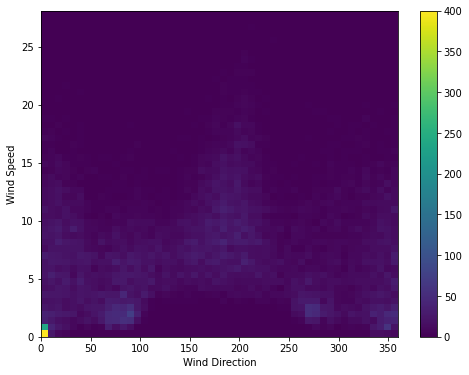

In [ ]:
plt.hist2d(df['Wind Direction'], df['Wind Speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed')

Pero esto será más fácil de interpretar para el modelo si se convierten las columnas de dirección y velocidad del viento en un vector de viento:

In [ ]:
# Convert to radians.
wd_rad = df.pop('Wind Direction')*np.pi / 180
wv = df.pop('Wind Speed')

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)


La distribución de los vectores del viento es mucho más sencilla para que el modelo la interprete correctamente.

(-26.569071974340957,
 23.669621109765025,
 -23.506982506164338,
 19.794032816030242)

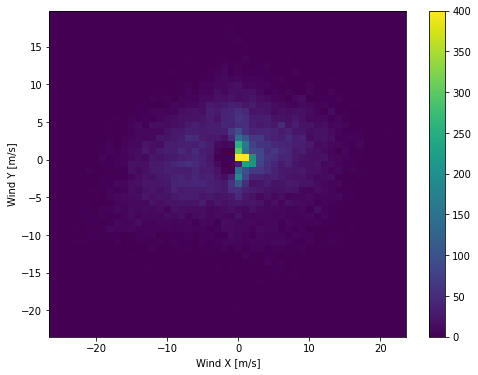

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Hora
De manera similar, la columna `datetime` es muy útil, pero no en esta forma de cadena. Por lo que se convierte en segundos:

In [ ]:
df['datetime'] = df.index
df.reset_index(drop=True, inplace=True)
date_time = pd.to_datetime(df.pop('datetime'), format='%Y-%m-%dT%H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)


Evolución de la característica `AQI` a lo largo del tiempo:

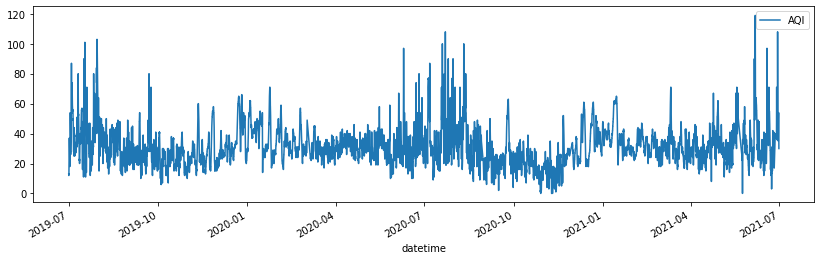

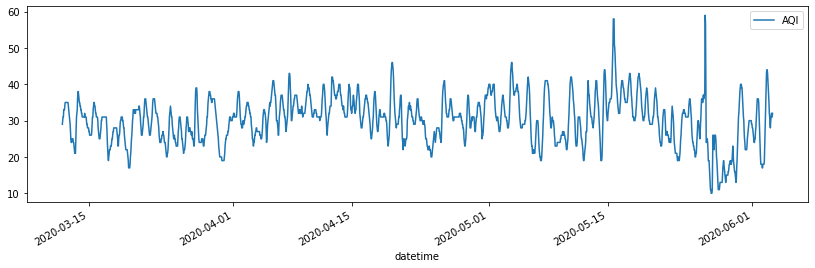

In [ ]:
plot_cols = ['AQI']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(14, 4))

plot_features = df[plot_cols][6000:8000]
plot_features.index = date_time[6000:8000]
_ = plot_features.plot(subplots=True, figsize=(14, 4))


Observando estas gráficas se puede confirmar fácilmente que la naturaleza de los datos se corresponde con series de tiempo estacionarias, teniendo claramente una periodicidad diaria y anual. El tiempo en segundos tampoco es de gran valor para el modelo, pero gracias a que se ha identificado que los datos son periódicos existe un método simple para convertir los segundos en una señal clara de “Hora del día” y “Hora del año” que es utilizando senos y cosenos.



In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Text(0.5, 1.0, 'Time of day signal')

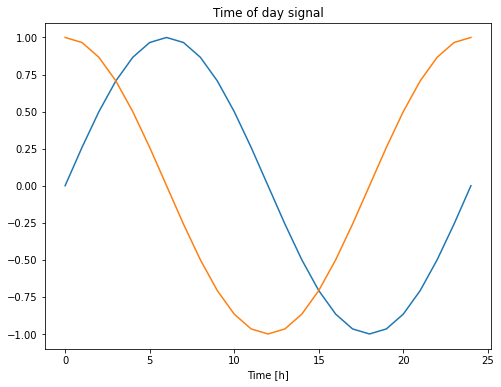

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Esto le da al modelo acceso a las características de frecuencia más importantes. 


### Guardado de cambios

Una vez analizados y preparados los datos históricos para realizar el modelo. Se procede a guardarlos en un archivo de tipo .csv

In [ ]:
print(df.shape)
df.to_csv(os.getcwd() + "/in_models/historical_data_to_model_2.csv", index=False)

(17141, 21)


Durante la realización de este documento se usarón textos y código provenientes de tensorflow (Apache License, Version 2.0, 2021)

Referencias:
    https://www.tensorflow.org/tutorials/structured_data/time_series